In [92]:
import json
import os
from backTrans.baidu_trans import backTrans as bt
import backTrans.baidu_trans
import json
from time import sleep
from tqdm import tqdm
from utils.utils import read_json_to_dataframe
import seaborn as sns
import matplotlib.pyplot as plt
from utils.preprocessor import Preprocessor

In [2]:
fail_path = 'backTrans/failFiles'
succ_path = 'backTrans/succFiles'
paths = [fail_path, succ_path]

In [3]:
for p in paths:
    d = os.listdir(p)
    print(p,len(d))

backTrans/failFiles 2240
backTrans/succFiles 98896


In [4]:
98896 + 2240

101136

## deal with fail Files

In [4]:
def get_num(p):
    return int(p[0:-5])

d = os.listdir(fail_path)
d = list(map(get_num,d))
d.sort()

In [ ]:
file_path = 'data/train/doc_quality_data_train.json'
ERROR = 'ERROR'
n = 0
with open(file_path, 'r') as f:
    for idx, line in enumerate(f):
        if idx > 101136:
            break
        if not idx in d:
            continue
        n += 1
        l = json.loads(line)
        q = l['body'].replace('\n', '#|#|#')
        s, re1, re2 = bt(q)
        if s == ERROR:
            with open('backTrans/temp/{}.json'.format(idx), 'w') as fail_f:
                json.dump([idx, l['id'], re1, re2], fail_f)
                print("WRONG with ", idx)
        else:
            with open('./succFiles/{}.json'.format(idx), 'w') as succ_f:
                json.dump([idx, l['id'], re1, re2], succ_f)
        print(f'\r {n}/{len(d)}', end = '')
        sleep(1.5)



## build dataset


In [48]:
def read_succ_file(p):
    try:
        l = json.load(open(p,'r'))
        id = l[1]
        src = l[2]['trans_result'][0]['src'].replace('#|#|#','\n')
        dst = l[3]['trans_result'][0]['dst'].replace('#|#|#','\n')
    except:
        return ERROR
    return {'id':id,'src':src,'dst':dst}

In [49]:
def get_num(p):
    return int(p[0:-5])

d = os.listdir(succ_path)
d = list(map(get_num,d))
d.sort()

In [50]:
ERROR = 'ERROR'
p = succ_path + '/' + '{}.json'
f_path = 'data/train/back_trans.json'
with open(f_path,'w') as f:
    for i in tqdm(d):
        c = read_succ_file(p.format(i))
        if c != ERROR:
            json.dump(c,f)
            f.write('\n')


100%|██████████| 98900/98900 [01:34<00:00, 1045.20it/s]


## read the dataset


In [53]:
d = read_json_to_dataframe(f_path)

In [54]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98027 entries, 0 to 98026
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      98027 non-null  object
 1   src     98027 non-null  object
 2   dst     98027 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [55]:
d.head()

,id,src,dst
0,0e7668c6-a98d-11eb-8239-7788095c0b0f,篮球——CBA第四阶段：辽宁本钢迎战吉林九台农场银行 \n新华社照片，诸暨（浙江），2021...,篮球-CBA第四阶段：辽宁本溪钢铁对阵吉林九台农场银行新华社照片，诸暨（浙江），2021年3...
1,0e766c68-a98d-11eb-8239-7788095c0b0f,这4种家电，有人相见恨晚，有人感觉鸡肋，主要是价格不一样同样一个产品，口碑却两极分化。感觉好...,有些人讨厌在这四种家电中相逢太晚，有些人觉得鸡排主要是因为价格不同，但同一产品的声誉是两极分...
2,0e766e70-a98d-11eb-8239-7788095c0b0f,PEHCHAOLIN 百雀羚 肌初赋活系列肌初赋活护肤套装聚划算折后单价283元，喜欢的值友...,Pehchaolin Baique muscle initial activation系列肌...
3,0e766fd8-a98d-11eb-8239-7788095c0b0f,XTEP 特步男鞋运动鞋男夏季透气2020年新品男士休闲鞋潮流老爹鞋男潮鞋特步男鞋运动鞋男夏...,XTEP special男鞋运动鞋男式夏季透气2020新款男式休闲鞋潮流dad's shoe...
4,0e7671cc-a98d-11eb-8239-7788095c0b0f,冲3连红，NBA预测：马刺VS鹈鹕，众星缺阵，鹈鹕迎来好机会凯尔特人118:112步行者，昨...,NBA预测，在明星缺席的情况下，马刺队对鹈鹕队将有一个很好的机会。凯尔特人118:112步行...


In [56]:
d['l_src'] = d.src.apply(lambda x: len(x))

In [57]:
d['l_dst'] = d.dst.apply(lambda x:len(x))

In [62]:
d['r'] = d.l_dst/d.l_src

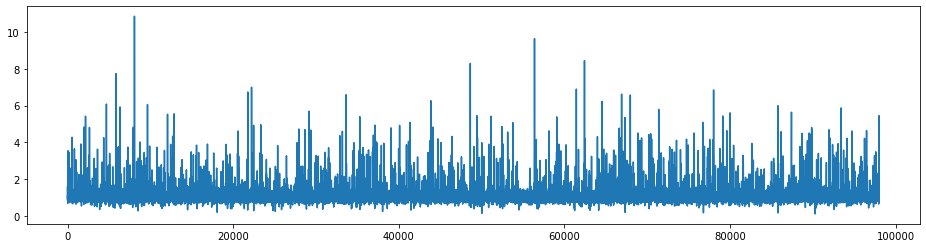

In [63]:
plt.figure(figsize=(16,4))
plt.plot(d.r)

In [68]:
d.r.quantile([0.9+di*0.01 for i in range(10)])

0.90    1.103271
0.91    1.114858
0.92    1.128571
0.93    1.145403
0.94    1.165414
0.95    1.192661
0.96    1.225806
0.97    1.275874
0.98    1.351351
0.99    1.621556
Name: r, dtype: float64

In [72]:
d_filtered = d[d.r < 1.2]
d_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93367 entries, 0 to 98026
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      93367 non-null  object 
 1   src     93367 non-null  object 
 2   dst     93367 non-null  object 
 3   l_src   93367 non-null  int64  
 4   l_dst   93367 non-null  int64  
 5   r       93367 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.0+ MB


In [75]:
d_drop = d[d.r > 4]

In [76]:
d_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 554 to 98010
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      101 non-null    object 
 1   src     101 non-null    object 
 2   dst     101 non-null    object 
 3   l_src   101 non-null    int64  
 4   l_dst   101 non-null    int64  
 5   r       101 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.5+ KB


In [88]:
d_drop['num_sent'] = d_drop.src.str.count('\n')

/home/yuanhang/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='num_sent', ylabel='Count'>

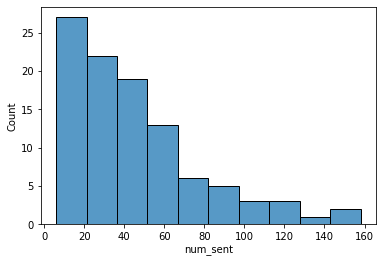

In [89]:
sns.histplot(d_drop.num_sent)

## check those reasonable samples

In [91]:
prep = Preprocessor()

TypeError: __init__() missing 1 required positional argument: 'bert_tokenizer_version'